# Case Study: How Does a Bike-Share Navigate Speedy Success?

This is a project part of the final module of Coursera's course [Google Data Analytics](https://www.coursera.org/professional-certificates/google-data-analytics).<br>
This project will answer some business questions of a fictional bike-share company called Cyclist.  
The data comes from Chicago Divvy bicycle sharing system and can be found [here](https://ride.divvybikes.com/system-data).<br> 
For this analysis data from all months of 2021 were used.  

**To guide a future marketing program we have three questions**
* How do annual members and casual riders use Cyclistic bikes differently?
* Why would casual riders buy Cyclistic annual memberships?
* How can Cyclistic use digital media to influence casual riders to become members?

Let's start by loading some packages.

In [1]:
library(tidyverse)
library(janitor)
library(skimr)
library(lubridate)
library(cowplot)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.5     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.0.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union



Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp




We have one CSV file for each month so each one will be assigned to a variable.

In [2]:
jan21<- read_csv("../input/divvytrips2021/202101-divvy-tripdata.csv")
feb21<- read_csv("../input/divvytrips2021/202102-divvy-tripdata.csv")
mar21<- read_csv("../input/divvytrips2021/202103-divvy-tripdata.csv")
apr21<- read_csv("../input/divvytrips2021/202104-divvy-tripdata.csv")
may21<- read_csv("../input/divvytrips2021/202105-divvy-tripdata.csv")
jun21<- read_csv("../input/divvytrips2021/202106-divvy-tripdata.csv")
jul21<- read_csv("../input/divvytrips2021/202107-divvy-tripdata.csv")
aug21<- read_csv("../input/divvytrips2021/202108-divvy-tripdata.csv")
sep21<- read_csv("../input/divvytrips2021/202109-divvy-tripdata.csv")
oct21<- read_csv("../input/divvytrips2021/202110-divvy-tripdata.csv")
nov21<- read_csv("../input/divvytrips2021/202111-divvy-tripdata.csv")
dec21<- read_csv("../input/divvytrips2021/202112-divvy-tripdata.csv")

Rows: 96834 Columns: 13

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (7): ride_id, rideable_type, start_station_name, start_station_id, end_...
dbl  (4): start_lat, start_lng, end_lat, end_lng
dttm (2): started_at, ended_at


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 49622 Columns: 13

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (7): ride_id, rideable_type, start_station_name, start_station_id, end_...
dbl  (4): start_lat, start_lng, end_lat, end_lng
dttm (2): started_at, ended_at


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 228496 Columns: 13

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
ch

Next, columns of all dataframes will be compared to see if there is a mismatch.

In [3]:
compare_df_cols(jan21,feb21,mar21,apr21,may21,jun21,jul21,aug21,sep21,oct21,nov21,dec21,return = "mismatch")

column_name,jan21,feb21,mar21,apr21,may21,jun21,jul21,aug21,sep21,oct21,nov21,dec21
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>


Since there is no mismatch all dataframes will be merged into one.

In [4]:
df2021<- bind_rows(jan21,feb21,mar21,apr21,may21,jun21,jul21,aug21,sep21,oct21,nov21,dec21)

Next, unused columns will be removed.

In [5]:
df2021<- select(df2021, -start_lat, -start_lng, -end_lat, -end_lng)

Some new calculated columns will be added.  
* The trip duration by calculating the difference in time of the start of the trip and the end of the trip.
* The day of the week of the start of the trip.
* The month of the start of the trip.
* The time (HH:MM) of the start of the trip

In [6]:
df2021<-mutate(df2021, trip_duration=as.double(difftime(ended_at, started_at)/60), day_of_week=format(as.Date(started_at),'%a'), month= format(as.Date(started_at),'%b'))
df2021<-mutate(df2021, time= strftime(started_at, format = "%H:%M"))
df2021<-mutate(df2021, time= as.POSIXct(df2021$time, format="%H:%M"))

Now let's have some information about the dataframe.

In [7]:
skim(df2021)

── Data Summary ────────────────────────
                           Values 
Name                       df2021 
Number of rows             5595063
Number of columns          13     
_______________________           
Column type frequency:            
  character                9      
  numeric                  1      
  POSIXct                  3      
________________________          
Group variables            None   

── Variable type: character ────────────────────────────────────────────────────
  skim_variable      n_missing complete_rate   min   max empty n_unique
1 ride_id                    0         1        16    16     0  5595063
2 rideable_type              0         1        11    13     0        3
3 start_station_name    690809         0.877     3    53     0      847
4 start_station_id      690806         0.877     3    36     0      834
5 end_station_name      739170         0.868    10    53     0      844
6 end_station_id        739170         0.868     3    36    

We can see that rideable_type and member_casual have 3 and 2 unique values respectively, let's check them.

In [8]:
unique(df2021[c("rideable_type")])
unique(df2021[c("member_casual")])

rideable_type
<chr>
electric_bike
classic_bike
docked_bike


member_casual
<chr>
member
casual


We can see that trip_duration has some negative values, let's remove those.

In [9]:
df2021<- filter(df2021, trip_duration>=0)

### Analyze and Visualize the Data

Now that the data is ready for analysis, let's create some dataframes by grouping data and calculate the number of rides, average, median, and the sum of trip duration for each group.
* First, a dataframe of grouped data by Type of bike and Customer type will be created.

In [10]:
biketype<- df2021 %>% 
  group_by(rideable_type, member_casual) %>% 
  summarize(number_rides= n(), mean_trip_duration= mean(trip_duration), median_trip_duration=median(trip_duration), sum_trip_duration= sum(trip_duration)) %>% 
  mutate(rideable_type= as.factor(rideable_type)) %>% 
  mutate(rideable_type= fct_relevel(rideable_type, "classic_bike", "electric_bike", "docked_bike"))

`summarise()` has grouped output by 'rideable_type'. You can override using the `.groups` argument.



* A dataframe grouped by Customer type and Day of the week.

In [11]:
dayweek<- df2021 %>% 
  group_by(member_casual, day_of_week) %>% 
  summarize(number_rides= n(), mean_trip_duration= mean(trip_duration), median_trip_duration=median(trip_duration), sum_trip_duration= sum(trip_duration)) %>% 
  mutate(day_of_week= fct_relevel(day_of_week, "Mon","Tue","Wed","Thu","Fri","Sat","Sun"))

`summarise()` has grouped output by 'member_casual'. You can override using the `.groups` argument.



* And a dataframed grouped by Customer type and Month.

In [12]:
month<- df2021 %>% 
  group_by(member_casual, month) %>% 
  summarize(number_rides= n(), mean_trip_duration= mean(trip_duration), median_trip_duration=median(trip_duration), sum_trip_duration= sum(trip_duration)) %>% 
  mutate(month= fct_relevel(month,"Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"))

`summarise()` has grouped output by 'member_casual'. You can override using the `.groups` argument.



Let's calculate some percentages as well.

In [13]:
percentages<- dayweek %>%
    group_by(member_casual) %>%
    summarise(mean_trip_duration=mean(mean_trip_duration), number_rides=sum(number_rides), sum_trip_duration=sum(sum_trip_duration)) %>%
    mutate(perc_number_rides=100*number_rides/(sum(number_rides)), perc_sum_trip_duration=100*sum_trip_duration/(sum(sum_trip_duration)))

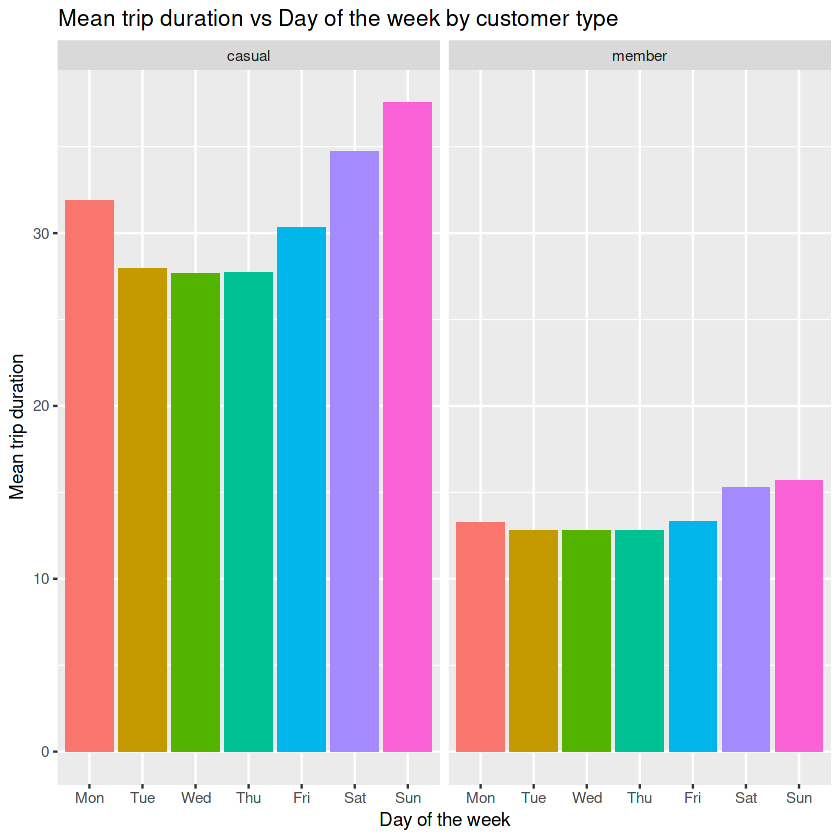

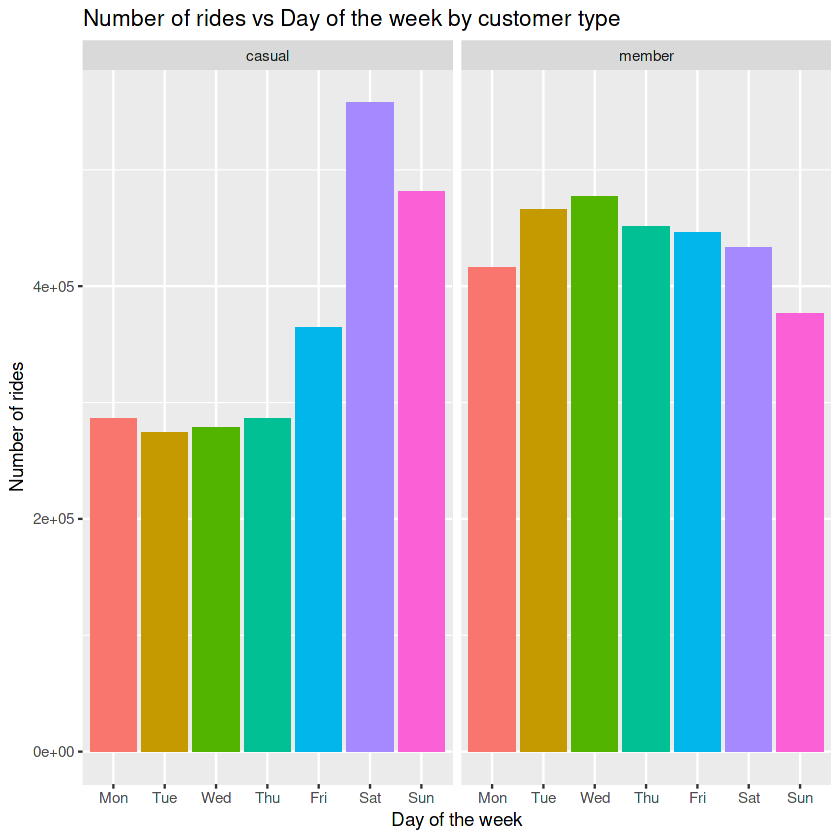

In [14]:
plot1<- dayweek %>%
  ggplot(aes(x=day_of_week, y=mean_trip_duration)) +
geom_col(aes(fill=day_of_week)) + 
labs(title = "Mean trip duration vs Day of the week by customer type", x="Day of the week", y= "Mean trip duration") +
facet_wrap(~member_casual) + 
theme(legend.position = "none") 


plot2<- dayweek %>%
  ggplot(aes(x=day_of_week, y=number_rides)) +
geom_col(aes(fill=day_of_week)) + 
labs(title = "Number of rides vs Day of the week by customer type", x="Day of the week", y= "Number of rides") + 
facet_wrap(~member_casual) + 
theme(legend.position = "none")

plot1
plot2

* The data shows that members have a more consistent average trip duration throughout the week, while casual customers have more trips on weekends.<br>
* Casual customers on average have around twice the trip duration of members.

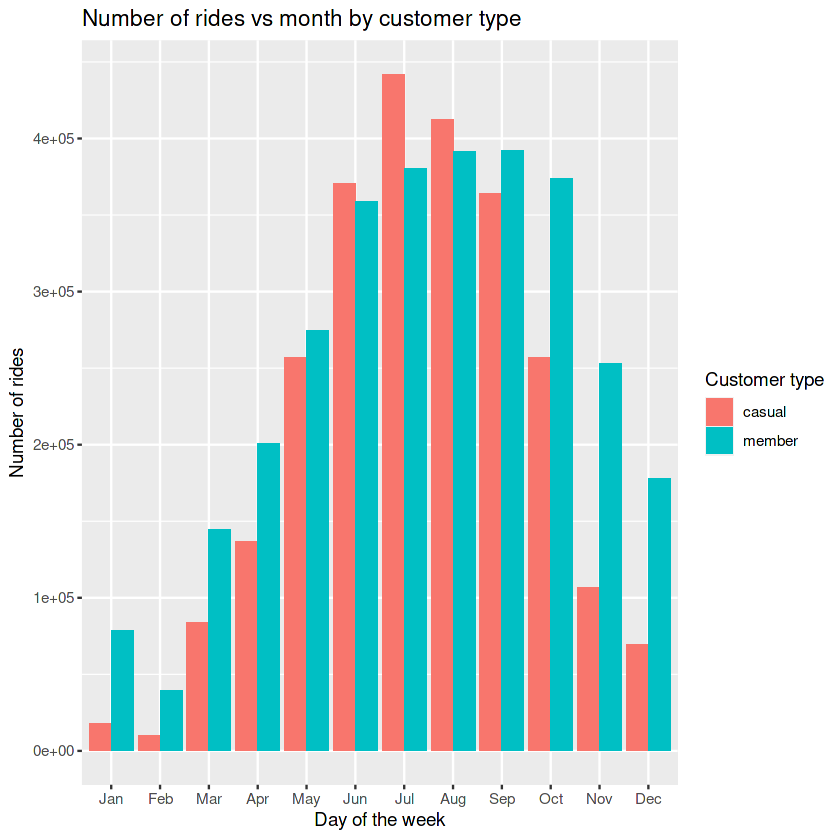

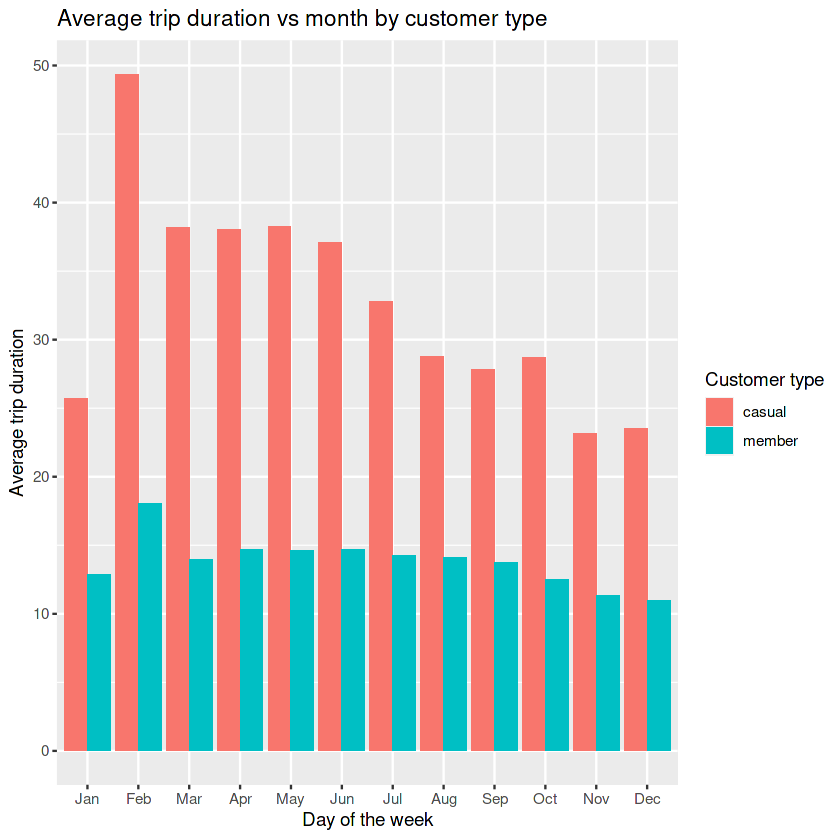

In [15]:
plot3<- month %>%
  ggplot(aes(x=month, y=number_rides)) +
geom_col(aes(fill=member_casual), position="dodge") + 
labs(title = "Number of rides vs month by customer type", x="Day of the week", y= "Number of rides", fill= "Customer type")

plot4<- month %>%
  ggplot(aes(x=month, y=mean_trip_duration)) +
geom_col(aes(fill=member_casual), position="dodge") + 
labs(title = "Average trip duration vs month by customer type", x="Day of the week", y= "Average trip duration", fill= "Customer type")

plot3
plot4

* Data shows that the average trip duration of members stays consistent thoughout the year as well.  
* Casual customers' trip duration is around twice the members' trip duration as well.
* The monthly number of trips data shows that the number of trips varies immensely, this is probably due to weather.

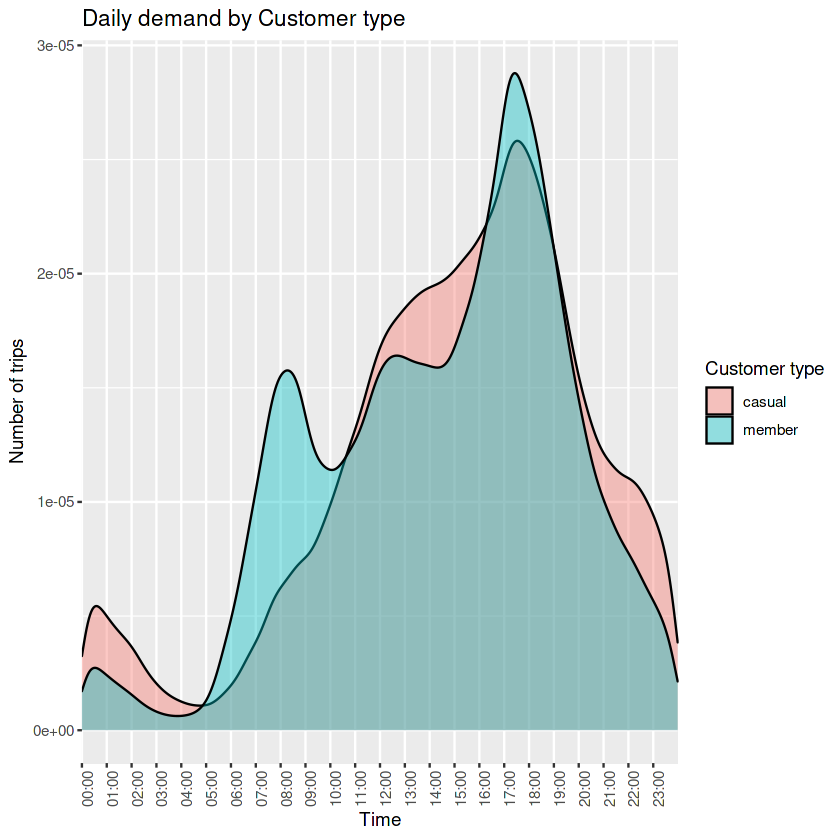

In [16]:
df2021 %>% 
  ggplot(aes(x=time)) +
  geom_density(aes(fill= member_casual),adjust=1.5 , alpha=.4) + 
scale_x_datetime(date_breaks = "1 hour", minor_breaks = NULL, date_labels = "%H:%M", expand = c(0,0)) +
theme(axis.text.x = element_text(angle = 90)) +
  labs(title ="Daily demand by Customer type", x= "Time", y= "Number of trips", fill="Customer type")

* The demand throughout the day shows that a great part of members are probably office-goers. <br>
* Casual customers tend to use the service mostly in the afternoon and early in the night.

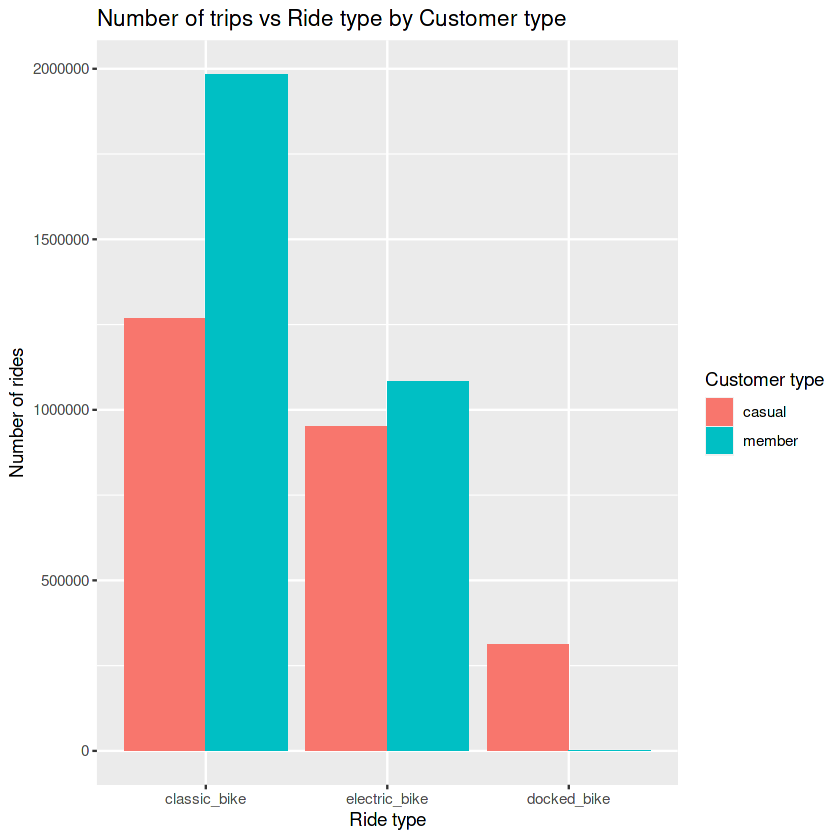

In [17]:
biketype %>% 
  ggplot(aes(x=rideable_type, y=number_rides)) +
  geom_col(aes(fill=member_casual), position= "dodge")+
  labs(title = "Number of trips vs Ride type by Customer type", x="Ride type", y= "Number of rides", fill= "Customer type")

* Classic bikes are preferred among customers.
* Almost twice the trips of members are on classic bikes compared to other types.
* Most casual customers trips are on classic bikes but a great part is with electric bikes.
* Docked bikes have the lowest amount of trips and practically only casual customers use them.

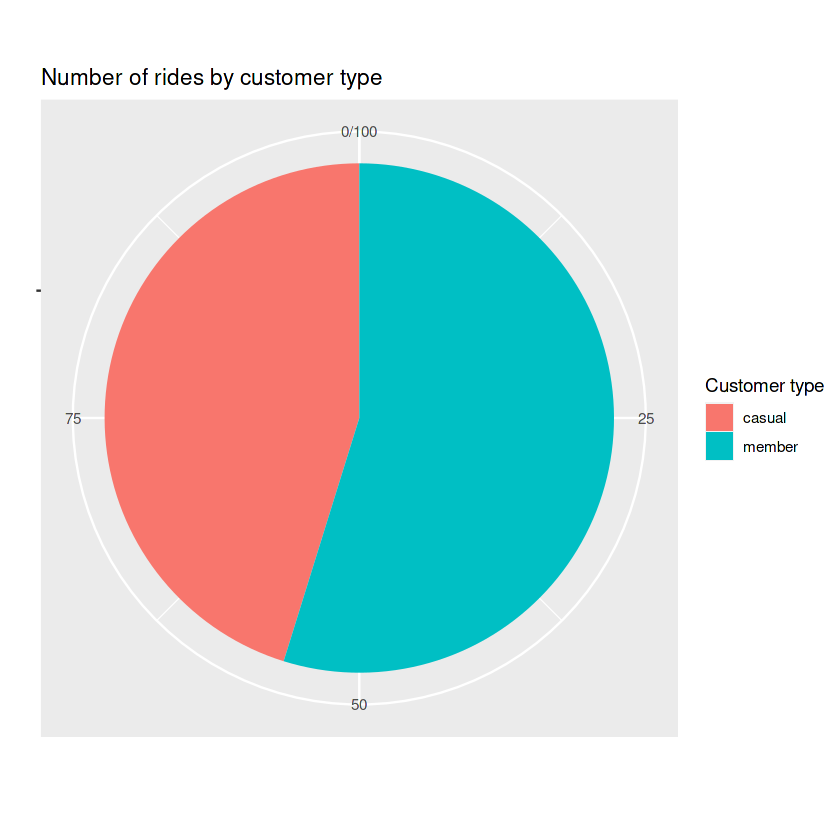

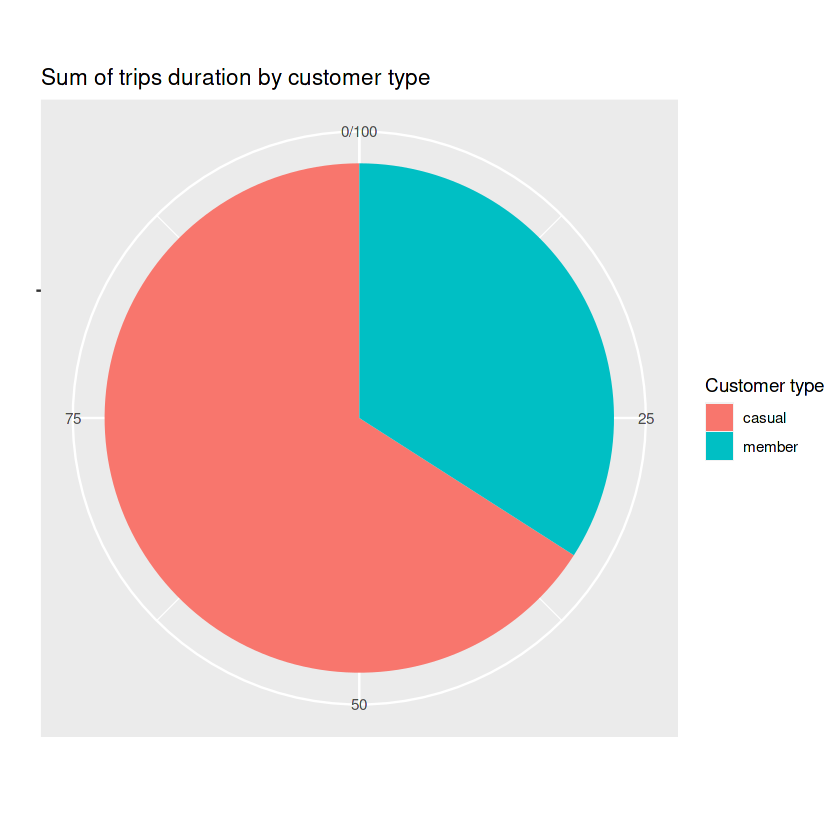

In [18]:
plot5<- percentages %>%
    ggplot(aes(x="", y=perc_number_rides, fill=member_casual)) +
  geom_bar(stat="identity", width=1) +
  coord_polar("y", start=0)+
    labs(fill= "Customer type", x="", y="", title= "Number of rides by customer type")
plot6<- percentages %>%
    ggplot(aes(x="", y=perc_sum_trip_duration, fill=member_casual)) +
  geom_bar(stat="identity", width=1) +
  coord_polar("y", start=0)+
    labs(fill= "Customer type", x="", y="", title= "Sum of trips duration by customer type")

plot5
plot6

In [19]:
percentages

member_casual,mean_trip_duration,number_rides,sum_trip_duration,perc_number_rides,perc_sum_trip_duration
<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
casual,31.11854,2528946,80931864,45.20079,65.94199
member,13.69692,3065970,41800052,54.79921,34.05801


Even though casual customers made fewer trips they spend almost twice the time using the service compared to members.

### Conclusion

**How do annual members and casual riders use Cyclistic bikes differently?**<br>
Members use bikes evenly throughout the week while casual users prefer the weekends. Casual users spend more than twice the time on a trip than members. The daily demand of the service shows a peak of rides around 7 am to 9 am for members and around 16 pm 19 pm for members and casual customers, this shows that probably most members use the service to commute to work/school, while casual customers use the service for leisure.

**Why would casual riders buy Cyclistic annual memberships?**<br>
Users would probably commit to an annual subscription if they plan to use the service substantially throughout the year, like using bikes to commute to work/school. Different membership options could appeal to more users, like weakly or monthly subscriptions.

**How can Cyclistic use digital media to influence casual riders to become members?**<br>
Cyclistic could use digital media to advertise to people that could use bikes to commute to work or school. To create better ads more data could be collected, like in a survey asking users some information or more data about the rides.